26/1/2024
Re-run of training using 5,100,100 chunks.
Using oversampling of positive (vascular map == 1) training data.

**Training Code**

Inputs are tensors of shape 5,100,100 representing 5 layers of normalised portion from 8 bit grayscale adjacent TIFF slices of kidney CT scan. 
Each 5 slice 100x100 pixel area is named a 'Chunk'. 
Labels are derived from a mask map that is either 0 (no vasculature) or 1 (vasculature) at a given pixel. Label that represents the centre of the chunk ie at 50,50 in the middle slice is used. 
Output for the model is a binary classification - either 0 (no vasculature) or 1 (vaculature).


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
import gc
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data import Dataset

from PIL import Image
import os
from IPython.display import display
from torchvision.transforms import ToPILImage
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import copy
import sys
import os
from torch.utils.data import Dataset
import pickle
from PIL import Image, ImageOps
import random
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from torch.utils.data import Dataset
import os
import torch
import torch.nn.functional as F
import torch.nn.init as init
import torch
import torch.nn.functional as F
import joblib  # For saving
import optuna
import random
# If you also need other functionalities from skopt, import as needed
# from skopt import gp_minimize, use_named_args, etc.
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import joblib
from optuna.visualization import plot_optimization_history

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.manual_seed(6)
np.random.seed(6)
random.seed(6)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
optuna.logging.disable_default_handler()  # Disable Optuna's default logging
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=6))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

##### create dataloader from train and test folders of chunks
#### aim for 1GB dataloaders


class CustomDataset(Dataset):
    def __init__(self, folder_path, load_fraction=1.0):
        self.folder_path = folder_path
        all_file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pt')]
        
        if load_fraction < 1.0:
            selected_indices = torch.randperm(len(all_file_paths))[:int(len(all_file_paths) * load_fraction)]
            self.file_paths = [all_file_paths[i] for i in selected_indices]
        else:
            self.file_paths = all_file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = torch.load(file_path)
        image = data['images']
        label = data['target_label']

        # Ensure the image is a float tensor
        image = image.float()

        # Normalize the image
        image = image / 65535.0  # Adjust for 16-bit image range

        # Squeeze the image in case it has an unnecessary extra dimension
        image = torch.squeeze(image, dim=1)

        return image, label

# Usage
# train_dataset = CustomDataset('path/to/train_data')
# test_dataset = CustomDataset('path/to/test_data')

    
    
# Replace these paths with your actual folder paths
#train_folder = 'chunks/train'
#test_folder = 'chunks/test'

#train_dataset = CustomDataset(train_folder)
#test_dataset = CustomDataset(test_folder)
# Placeholder for batch size - replace with your calculated value

# Load only 50% of the data
#train_dataset = CustomDataset('path/to/train_data', load_fraction=0.5)
#train_loader = DataLoader(train_dataset, batch_size=your_batch_size, shuffle=True, num_workers=your_num_workers)





In [4]:
train_folder = '/kaggle/input/vascularchunks1/train_chunks'
test_folder = '/kaggle/input/vascularchunks1/test_chunks'
#train_folder = 'chunks/train'
#test_folder = 'chunks/test'




In [5]:
#### Model for 5* 100 * 100 images

class BinaryClassificationCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(BinaryClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(5, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)  # 50% dropout
        self.fc1 = nn.Linear(64 * 25 * 25, 128)  # Adjust the input size here
        self.fc2 = nn.Linear(128, 2)  # Output layer for binary classification

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)  # Adjust the input size here
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x


In [6]:

class ModelTrainer:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device, num_epochs=40, accumulation_steps=4):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.num_epochs = num_epochs
        self.accumulation_steps = accumulation_steps
        self.best_model = None
        self.best_accuracy = 0
        self.best_epoch = 0

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for i, data in enumerate(self.train_loader, 0):
            inputs, labels = data[0].to(self.device), data[1].to(self.device)
            labels = labels.squeeze()
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()

            if (i + 1) % self.accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()

            running_loss += loss.item()

        # Average loss for the epoch
        avg_loss = running_loss / len(self.train_loader)
        return avg_loss

    def evaluate(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(self.device), data[1].to(self.device)
                if labels.dim() == 0:
                    # Skip accuracy calculation for this batch
                    continue
                labels = labels.squeeze()
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                try:
                    total += labels.size(0)
                except:
                    print(f'labels size 0 caused an error: {labels}')
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total  # Convert to percentage
        return accuracy

    def train(self):
        for epoch in range(self.num_epochs):
            avg_loss = self.train_epoch()
            training_acc = self.evaluate(self.train_loader)
            test_acc = self.evaluate(self.test_loader)
            print(f'Epoch {epoch + 1}/{self.num_epochs} completed. Loss: {avg_loss:.4f}, Training Accuracy: {training_acc:.4f}, Test Accuracy: {test_acc:.4f}')

            # Check if current model is the best model
            if test_acc > self.best_accuracy:
                self.best_accuracy = test_acc
                self.best_epoch = epoch + 1
                self.best_model = copy.deepcopy(self.model)
                print(f"New best model found at epoch {self.best_epoch} with Test Accuracy: {self.best_accuracy:.4f}")

        print('Finished Training')
        return self.best_epoch, self.best_accuracy, self.best_model


In [7]:
##### UNUSED CODE ####
##### not used, saved in case we need to re check surface dice method
class BinaryClassificationEvaluator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        total = 0
        correct = 0
        predicted_labels = []
        true_labels = []

        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(self.device), data[1].to(self.device)
                labels = labels.squeeze()
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Move tensors to CPU and convert to numpy arrays
                true_labels.extend(labels.cpu().numpy().flatten().astype(int))
                predicted_labels.extend(predicted.cpu().numpy().flatten().astype(int))

        # Calculate accuracy
        accuracy = correct / total

        # Calculate precision, recall, and F1 score
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        # Calculate confusion matrix
        confusion = confusion_matrix(true_labels, predicted_labels)

        # Calculate Surface Dice Score
        surface_dice_score = self.calculate_surface_dice(true_labels, predicted_labels)

        return accuracy, precision, recall, f1, confusion, surface_dice_score

    def calculate_surface_dice(self, true_labels, predicted_labels):
        # Convert lists to numpy arrays
        true_mask = np.array(true_labels)
        predicted_mask = np.array(predicted_labels)

        # Calculate Surface Dice Score
        intersection = np.sum(true_mask * predicted_mask)
        union = np.sum(true_mask) + np.sum(predicted_mask)
        surface_dice_score = (2.0 * intersection) / union if union > 0 else 1.0

        return surface_dice_score


In [8]:
########### Oversampling of positive values as too many false positives and the true map has < 1% positive values ##########

In [9]:
import os
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, folder_path, load_fraction=1.0):
        self.folder_path = folder_path
        all_file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pt')]

        if load_fraction < 1.0:
            selected_indices = torch.randperm(len(all_file_paths))[:int(len(all_file_paths) * load_fraction)]
            self.file_paths = [all_file_paths[i] for i in selected_indices]
        else:
            self.file_paths = all_file_paths

        # Load labels for all files for weighted sampling
        self.labels = [torch.load(file_path)['target_label'] for file_path in self.file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = torch.load(file_path)
        image = data['images']
        label = data['target_label']

        # Image processing
        image = image.float()
        image = image / 65535.0
        image = torch.squeeze(image, dim=1)

        return image, label



In [10]:
from torch.utils.data import DataLoader, WeightedRandomSampler

def prep_loader_oversampling(dataset, batch_size, class_weights):
    # Convert labels from tensors to integers
 
    labels_as_integers = [label.item() for label in dataset.labels]

    # Calculate weights for each instance in the dataset
    sample_weights = [class_weights[label] for label in labels_as_integers]

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create and return the DataLoader
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, drop_last=True)



In [11]:
import joblib
import torch.optim as optim
import torch.nn as nn

def objective_oversampling(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.7)
    batch_size = trial.suggest_int('batch_size', 8, 32)
    #batch_size = 12

    # Define class weights for oversampling
    class_weights = {0: 0.3, 1: 0.7}  # Modify as needed
    default_class_weights = {0: 0.5, 1: 0.5}
    # Set up data loaders with oversampling
    train_loader = prep_loader_oversampling(train_dataset, batch_size, class_weights)
    test_loader = prep_loader_oversampling(test_dataset, batch_size, default_class_weights)  # Assuming normal loader for test set

    # Initialize the model
    model = BinaryClassificationCNN(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Train the model
    trainer = ModelTrainer(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=100)
    _, best_accuracy, best_model = trainer.train()

    # Save the model and hyperparameters
    save_path = f"/kaggle/working/model_lr_{learning_rate}_momentum_{momentum}_dropout_{dropout_rate}_batch_{batch_size}.pkl"
    joblib.dump({'model': best_model, 'params': {'learning_rate': learning_rate, 'momentum': momentum, 'dropout_rate': dropout_rate, 'batch_size': batch_size}, 'best_accuracy': best_accuracy}, save_path)
    ## Save the study object
    try:
        
        joblib.dump(study, "/kaggle/working/optuna_study_oversampling.pkl")
        with open("/kaggle/working/optuna_study_oversampling.pkl", "wb") as study_file:
            pickle.dump(study, study_file)
        trial = study.best_trial

        print(f" Value: {trial.value}")
        print(" Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")
        print(f'Trial best value is: {trial.best_accuracy}')
        # Print the best trial number and parameters
        #best_trial = study.best_trial
        #print(f"Best Trial - Number: {best_trial.number}")
        #print("Best Trial - Parameters:")
        #for key, value in best_trial.params.items():
        #    print(f"    {key}: {value}")
        #print(f"Best Accuracy: {best_accuracy}")
    except Exception as e:
    # Handle the exception
        print(f"An error occurred: {e}")
    # The code continues after this block


    return best_accuracy


In [12]:
# Define class weights
class_weights = {0: 0.3, 1: 0.7}

# Create dataset instances
train_folder = '/kaggle/input/vascularchunks1/train_chunks'
test_folder = '/kaggle/input/vascularchunks1/test_chunks'
#train_folder = 'chunks/train'
#test_folder = 'chunks/test'

train_dataset = CustomDataset(train_folder)
test_dataset = CustomDataset(test_folder)


# Define batch size
#batch_size = 32

# Prepare DataLoaders
#train_loader = prep_loader_oversampling(train_dataset, batch_size, class_weights)
#test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Assuming no class weighting for testing




In [13]:
# Use train_loader and test_loader in your training and testing loops
########### USE CODE BELOW TO TRAIN 2024 01 
########### CODE BELOW COMMENTED OUT - UNCOMMENT FOR TRAINING RUN ##################
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_oversampling, n_trials=30)

In [14]:
########## CODE TO LOAD TRIAL DATA


study_path = '/kaggle/input/capstone-2024-write-up/optuna_study_oversampling.pkl'

try:
    study = joblib.load(study_path)
    # You can now access and analyze the loaded study
except Exception as e:
    print(f"Error loading the joblib file: {e}")


In [15]:
#print("Best trial:")
trial = study.best_trial

print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
joblib.dump(study, "/kaggle/working/optuna_study_oversampling.pkl")

 Value: 88.43537414965986
 Params: 
    learning_rate: 0.0024435642230605137
    momentum: 0.9521176292803581
    dropout_rate: 0.6827284555071912
    batch_size: 21


['/kaggle/working/optuna_study_oversampling.pkl']

In [16]:
####### load the best model

model_path = '/kaggle/input/best-model-2024-01/model_lr_0.0024435642230605137_momentum_0.9521176292803581_dropout_0.6827284555071912_batch_21.pkl'

try:
    loaded_model = joblib.load(model_path)
    # You now have the loaded model in the 'loaded_model' variable
except Exception as e:
    print(f"Error loading the model: {e}")


In [17]:
import optuna
import joblib

study_path = '/kaggle/input/capstone-2024-write-up/optuna_study_oversampling.pkl'

try:
    study = joblib.load(study_path)
    # You can now access and analyze the loaded study
    
    # Iterate over each trial and find the result
    for trial in study.trials:
        trial_number = trial.number
        result = trial.value  # The result of the trial's objective function
        print(f"Trial {trial_number}: Result = {result}")
except Exception as e:
    print(f"Error loading the joblib file: {e}")


Trial 0: Result = 58.04195804195804
Trial 1: Result = 57.142857142857146
Trial 2: Result = 81.25
Trial 3: Result = 57.79220779220779
Trial 4: Result = 84.66666666666667
Trial 5: Result = 55.46875
Trial 6: Result = 84.86842105263158
Trial 7: Result = 63.19444444444444
Trial 8: Result = 88.43537414965986
Trial 9: Result = 56.94444444444444
Trial 10: Result = 85.33333333333333
Trial 11: Result = 83.84615384615384
Trial 12: Result = 56.52173913043478
Trial 13: Result = 84.28571428571429
Trial 14: Result = 84.21052631578948
Trial 15: Result = 58.0
Trial 16: Result = 86.84210526315789
Trial 17: Result = 86.39455782312925
Trial 18: Result = 85.0
Trial 19: Result = 58.169934640522875
Trial 20: Result = 85.41666666666667
Trial 21: Result = 86.36363636363636
Trial 22: Result = 84.05797101449275
Trial 23: Result = 83.11688311688312
Trial 24: Result = 78.57142857142857
Trial 25: Result = 86.66666666666667
Trial 26: Result = 85.33333333333333
Trial 27: Result = 57.638888888888886
Trial 28: Result =

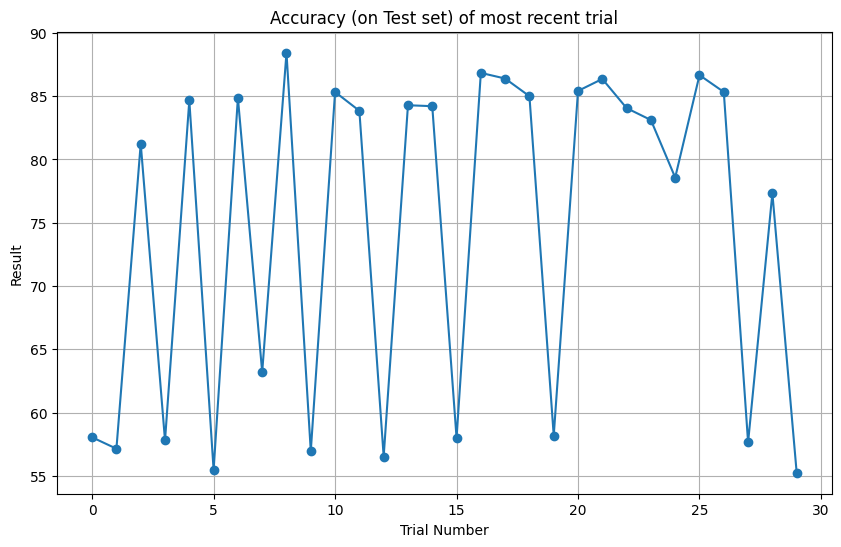

In [18]:
import optuna
import joblib
import matplotlib.pyplot as plt

study_path = '/kaggle/input/capstone-2024-write-up/optuna_study_oversampling.pkl'

try:
    study = joblib.load(study_path)
    # You can now access and analyze the loaded study
    
    # Initialize lists to store trial numbers and results
    trial_numbers = []
    results = []
    
    # Iterate over each trial and collect trial number and result
    for trial in study.trials:
        trial_numbers.append(trial.number)
        results.append(trial.value)
    
    # Create a plot of results vs. trial number
    plt.figure(figsize=(10, 6))
    plt.plot(trial_numbers, results, marker='o', linestyle='-')
    plt.xlabel('Trial Number')
    plt.ylabel('Result')
    plt.title('Accuracy (on Test set) of most recent trial')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error loading the joblib file: {e}")


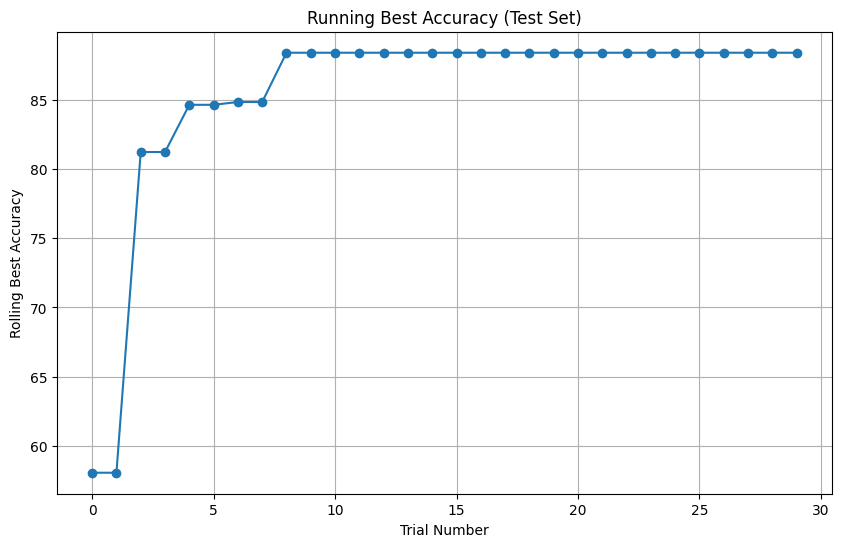

In [19]:
import optuna
import joblib
import matplotlib.pyplot as plt

study_path = '/kaggle/input/capstone-2024-write-up/optuna_study_oversampling.pkl'

try:
    study = joblib.load(study_path)
    # You can now access and analyze the loaded study
    
    # Initialize lists to store trial numbers and cumulative best results
    trial_numbers = []
    cumulative_best_results = []
    current_best = float('-inf')  # Initialize with negative infinity
    
    # Iterate over each trial and collect trial number and best result
    for trial in study.trials:
        trial_number = trial.number
        result = trial.value
        if result > current_best:
            current_best = result  # Update the current best result if a new best is found
        trial_numbers.append(trial_number)
        cumulative_best_results.append(current_best)
    
    # Create a plot of cumulative best results vs. trial number
    plt.figure(figsize=(10, 6))
    plt.plot(trial_numbers, cumulative_best_results, marker='o', linestyle='-')
    plt.xlabel('Trial Number')
    plt.ylabel('Rolling Best Accuracy')
    plt.title('Running Best Accuracy (Test Set)')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error loading the joblib file: {e}")
